In [4]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.6 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-10640.231, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-11051.254, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=-11501.007, Time=1.14 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=-10647.796, Time=0.49 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=-11515.484, Time=1.46 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=-11050.988, Time=0.60 sec
 ARIMA(0,1,1)(2,1,1)[5]             : AIC=-11493.724, Time=2.68 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=-11580.161, Time=4.39 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=-11595.737, Time=3.02 sec
 ARIMA(0,1,0)(0,1,2)[5]             : AIC=inf, Time=3.80 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=-11594.288, Time=1.95 sec
 ARIMA(0,1,2)(0,1,2)[5]             : AIC=-11594.999, Time=5.83 sec
 ARIMA(1,1,0)(0,1,2)[5]             : AIC=-11596.199, Time=1.67 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=-11501.460, Time=1.79 sec
 ARIMA(1,1,0

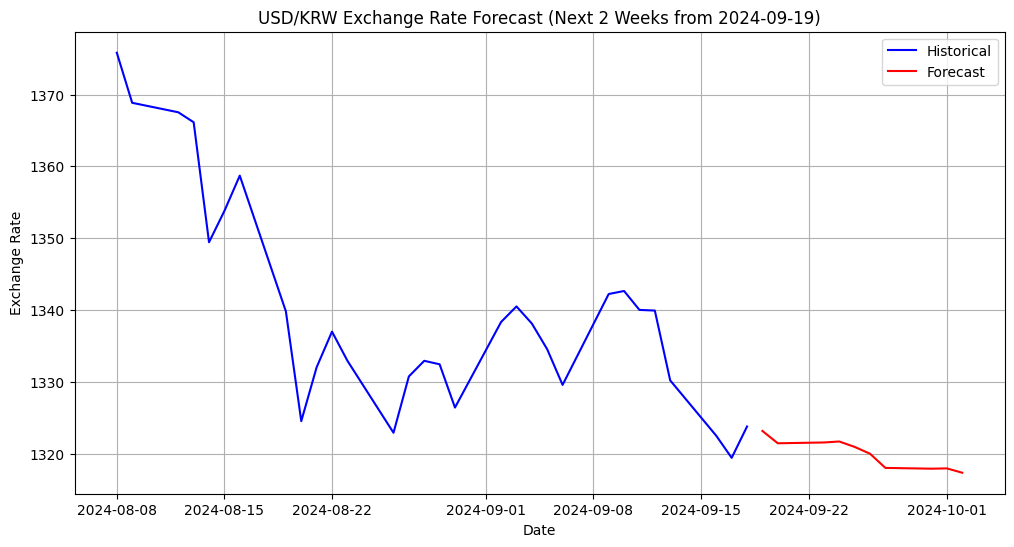


향후 2주 예측 결과 (시작일: 2024-09-19):
2024-09-19 00:00:00+01:00    1323.151599
2024-09-20 00:00:00+01:00    1321.433556
2024-09-23 00:00:00+01:00    1321.547116
2024-09-24 00:00:00+01:00    1321.683461
2024-09-25 00:00:00+01:00    1320.928878
2024-09-26 00:00:00+01:00    1319.979674
2024-09-27 00:00:00+01:00    1318.003607
2024-09-30 00:00:00+01:00    1317.895071
2024-10-01 00:00:00+01:00    1317.936012
2024-10-02 00:00:00+01:00    1317.333735
Freq: B, dtype: float64

향후 2주 평균 예측 환율: 1319.99
95% 신뢰구간: 1315.97 - 1324.01

일일 변동폭 (%):
2024-09-20 00:00:00+01:00   -0.129845
2024-09-23 00:00:00+01:00    0.008594
2024-09-24 00:00:00+01:00    0.010317
2024-09-25 00:00:00+01:00   -0.057093
2024-09-26 00:00:00+01:00   -0.071859
2024-09-27 00:00:00+01:00   -0.149704
2024-09-30 00:00:00+01:00   -0.008235
2024-10-01 00:00:00+01:00    0.003106
2024-10-02 00:00:00+01:00   -0.045699
Freq: B, dtype: float64

평균 일일 변동폭: -0.05%
최대 일일 변동폭: 0.01%


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 현재 날짜 가져오기
current_date = datetime.now().strftime('%Y-%m-%d')

# 데이터 가져오기 (현재 날짜까지)
usd_krw = yf.Ticker("KRW=X")
data = usd_krw.history(start="2019-01-01", end=current_date)

# 수준 변수 계산 및 로그 변환
data['Level'] = np.log((data['High'] + data['Low']) / 2)

# 빈도 정보 추가 및 결측치 처리
data = data.asfreq('B')
data['Level'] = data['Level'].interpolate()

# 전체 데이터를 학습 데이터로 사용
train_data = data['Level']

# 최적의 SARIMA 모델 파라미터 찾기
auto_model = auto_arima(train_data, seasonal=True, m=5,
                        start_p=0, start_q=0, max_p=5, max_q=5,
                        start_P=0, start_Q=0, max_P=2, max_Q=2,
                        d=1, D=1, trace=True, error_action='ignore',
                        suppress_warnings=True, stepwise=True)

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print(f"Best SARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# 2주(10 영업일) 예측 함수
def forecast_next_2_weeks(train, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=10)
    return np.exp(forecast.values)  # 로그 변환 원복

# 2주 예측 실행
last_date = train_data.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=10, freq='B')
forecast = forecast_next_2_weeks(train_data, best_order, best_seasonal_order)
forecast = pd.Series(forecast, index=future_dates)

# 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(train_data.index[-30:], np.exp(train_data[-30:].values), label='Historical', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title(f'USD/KRW Exchange Rate Forecast (Next 2 Weeks from {current_date})')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# 예측 결과 출력
print(f"\n향후 2주 예측 결과 (시작일: {current_date}):")
print(forecast)

# 평균 예측값 계산
average_forecast = forecast.mean()
print(f"\n향후 2주 평균 예측 환율: {average_forecast:.2f}")

# 신뢰구간 계산 (예: 95% 신뢰구간)
confidence_interval = 1.96 * forecast.std()
lower_bound = average_forecast - confidence_interval
upper_bound = average_forecast + confidence_interval
print(f"95% 신뢰구간: {lower_bound:.2f} - {upper_bound:.2f}")

# 일일 변동폭 계산
daily_changes = forecast.pct_change().dropna()
print("\n일일 변동폭 (%):")
print(daily_changes * 100)
print(f"\n평균 일일 변동폭: {daily_changes.mean() * 100:.2f}%")
print(f"최대 일일 변동폭: {daily_changes.max() * 100:.2f}%")